In [5]:
# =========================================================
# RAF-DB 4-Class Emotion Classification with ViT-Base
# =========================================================

import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd


# 1. SETTINGS
# =========================================================
DATASET_DIR = "/kaggle/input/raf-db-dataset"

train_csv = os.path.join(DATASET_DIR, "train_labels.csv")
test_csv = os.path.join(DATASET_DIR, "test_labels.csv")

# Corrected paths pointing to DATASET/
train_images_dir = os.path.join(DATASET_DIR, "DATASET/train")
test_images_dir = os.path.join(DATASET_DIR, "DATASET/test")

BATCH_SIZE = 32
NUM_EPOCHS = 5
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Keep only stable classes: angry=1, happy=4, neutral=5, sad=6
ALLOWED_CLASSES = [1, 4, 5, 6]
CLASS_NAMES = ["angry", "happy", "neutral", "sad"]

print("Using device:", DEVICE)

Using device: cuda


In [6]:
# =========================================================
# 2. TRANSFORMS
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.3),
    transforms.ToTensor(),  # Convert to tensor first
    transforms.Normalize((0.5,)*3, (0.5,)*3),
    transforms.RandomErasing(p=0.2, scale=(0.02,0.15), ratio=(0.3,3))  # After tensor
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

In [11]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

# =========================================================
# 4. DATALOADERS (UPDATED)
# =========================================================

# 1. Create TWO instances of the training data source
# Instance A: For actual training (Uses train_transform with augmentation)
train_data_aug = RAFDBDataset(
    images_dir=train_images_dir,
    labels_csv=train_csv,
    allowed_classes=ALLOWED_CLASSES,
    transform=train_transform
)

# Instance B: For validation (Uses test_transform -> NO augmentation, just resize/norm)
# We point this to the SAME training images/csv, but apply the clean transform
val_data_clean = RAFDBDataset(
    images_dir=train_images_dir,
    labels_csv=train_csv,
    allowed_classes=ALLOWED_CLASSES,
    transform=test_transform
)

# 2. Extract labels to ensure stratified split
# We try to access .labels or .targets (common conventions). 
# If your dataset class doesn't store labels in a list, we iterate to get them.
try:
    if hasattr(train_data_aug, 'labels'):
        targets = train_data_aug.labels
    elif hasattr(train_data_aug, 'targets'):
        targets = train_data_aug.targets
    else:
        # Fallback: Manually iterate (slower, but works for any dataset)
        targets = [y for _, y in train_data_aug]
except Exception:
    print("Warning: Could not extract labels efficiently. Splitting randomly (not stratified).")
    targets = None

# 3. Generate Stratified Indices
# We create a list of indices [0, 1, ... len(data)] and split that list
train_idx, val_idx = train_test_split(
    np.arange(len(train_data_aug)),
    test_size=0.2,             # 20% Validation
    shuffle=True,
    stratify=targets,          # Ensures balanced classes
    random_state=42            # Reproducible split
)

# 4. Create Subsets
# We use the indices to pick samples from the specific dataset instance we want
train_dataset = Subset(train_data_aug, train_idx)   # Pulls from augmented data
val_dataset   = Subset(val_data_clean, val_idx)     # Pulls from clean data

# Test dataset remains unchanged
test_dataset = RAFDBDataset(
    images_dir=test_images_dir,
    labels_csv=test_csv,
    allowed_classes=ALLOWED_CLASSES,
    transform=test_transform
)

# 5. Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")
print(f"Test  samples: {len(test_dataset)}")

Number of classes: 4
Train samples: 6999
Val   samples: 1750
Test  samples: 2154


In [12]:
# 1. Create the Pre-trained ViT Model
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=len(CLASS_NAMES),
    drop_path_rate=0.1  # Helps prevent overfitting (Stochastic Depth)
).to(DEVICE)

# 2. FREEZE the entire model first (The Backbone)
# We turn off gradient calculation for every single parameter.
for param in model.parameters():
    param.requires_grad = False

# 3. UNFREEZE only the Classifier Head
# In timm ViT models, the final classification layer is usually named 'head'.
# We verify this exists, then enable gradients for it.
if hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True
    print("Backbone frozen. Only 'head' layer is trainable.")
else:
    # Fallback if the layer name is different (rare for this model)
    print("Warning: Could not find 'head'. Unfreezing last layer manually.")
    for param in list(model.parameters())[-2:]: # Last weight and bias
        param.requires_grad = True

# =========================================================
# 6. OPTIMIZER & LOSS
# =========================================================

# Criterion: Label Smoothing helps ViT generalize better on small data
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Pass ONLY the parameters that require gradients
# (This is more efficient than passing all parameters)
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(
    trainable_params, 
    lr=LR,            # Use your standard LR for the head (e.g., 1e-3 or 3e-4)
    weight_decay=0.05 # Higher weight decay is good for ViTs
)

# Scheduler: Standard cosine annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# =========================================================
# HOW TO UNFREEZE LATER (OPTIONAL)
# =========================================================
# After training for 5-10 epochs, if you want to fine-tune the whole model:
def unfreeze_all_layers(model, new_lr=1e-5):
    # 1. Enable grads for everything
    for param in model.parameters():
        param.requires_grad = True
    
    # 2. You MUST re-create the optimizer to include the new parameters
    # Note: Use a MUCH lower learning rate (10x - 100x smaller) to preserve pre-training
    new_optimizer = optim.AdamW(
        model.parameters(), 
        lr=new_lr, 
        weight_decay=0.05
    )
    
    print("All layers unfrozen. Optimizer recreated with low LR.")
    return new_optimizer

Backbone frozen. Only 'head' layer is trainable.


❄️  PHASE 1: Training Head Only for 5 epochs...


Epoch 1/15 [Head-Only]: 100%|██████████| 219/219 [01:23<00:00,  2.63it/s, loss=0.667]


   Trace: Val Acc=0.7606


Epoch 2/15 [Head-Only]: 100%|██████████| 219/219 [01:20<00:00,  2.72it/s, loss=0.972]


   Trace: Val Acc=0.7857


Epoch 3/15 [Head-Only]: 100%|██████████| 219/219 [01:19<00:00,  2.75it/s, loss=0.912]


   Trace: Val Acc=0.7943


Epoch 4/15 [Head-Only]: 100%|██████████| 219/219 [01:19<00:00,  2.75it/s, loss=0.695]


   Trace: Val Acc=0.8091


Epoch 5/15 [Head-Only]: 100%|██████████| 219/219 [01:19<00:00,  2.74it/s, loss=0.664]


   Trace: Val Acc=0.8069

🔓 PHASE 2: Unfreezing All Layers for 10 epochs...
   (Switching to lower learning rate: 1e-5)


Epoch 6/15 [Full-Body]: 100%|██████████| 219/219 [02:49<00:00,  1.29it/s, loss=0.493]


   Trace: Val Acc=0.8880


Epoch 7/15 [Full-Body]: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s, loss=0.53] 


   Trace: Val Acc=0.9040


Epoch 8/15 [Full-Body]: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s, loss=0.674]


   Trace: Val Acc=0.9280


Epoch 9/15 [Full-Body]: 100%|██████████| 219/219 [02:49<00:00,  1.29it/s, loss=0.424]


   Trace: Val Acc=0.9063


Epoch 10/15 [Full-Body]: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s, loss=0.408]


   Trace: Val Acc=0.9314


Epoch 11/15 [Full-Body]: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s, loss=0.445]


   Trace: Val Acc=0.9337


Epoch 12/15 [Full-Body]: 100%|██████████| 219/219 [02:49<00:00,  1.30it/s, loss=0.424]


   Trace: Val Acc=0.9337


Epoch 13/15 [Full-Body]: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s, loss=0.381]


   Trace: Val Acc=0.9371


Epoch 14/15 [Full-Body]: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s, loss=0.368]


   Trace: Val Acc=0.9366


Epoch 15/15 [Full-Body]: 100%|██████████| 219/219 [02:49<00:00,  1.29it/s, loss=0.391]


   Trace: Val Acc=0.9371


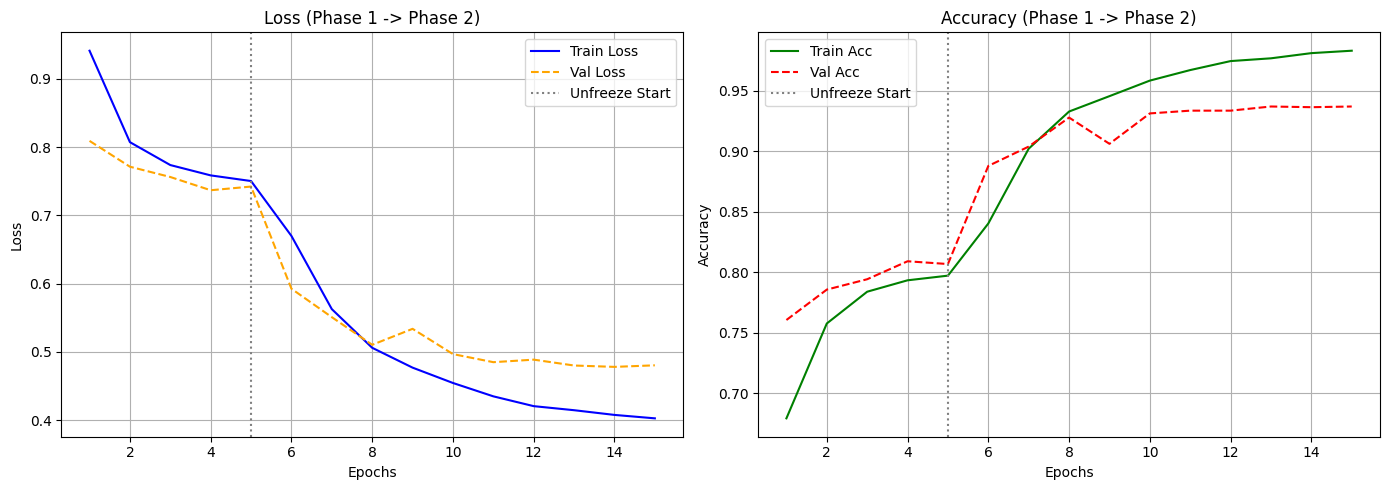

In [13]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm

# =========================================================
# CONFIGURATION
# =========================================================
# Phase 1: Train ONLY the head (Linear Probing)
WARMUP_EPOCHS = 5      
# Phase 2: Train the whole model (Fine-Tuning)
FINE_TUNE_EPOCHS = 10  

# Total epochs for the plot
TOTAL_EPOCHS = WARMUP_EPOCHS + FINE_TUNE_EPOCHS

# Metric storage (continuous lists for both phases)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# =========================================================
# HELPER: UNFREEZE FUNCTION
# =========================================================
def unfreeze_all_layers(model, new_lr=1e-5):
    """Unfreezes all layers and returns a new optimizer with a low LR."""
    for param in model.parameters():
        param.requires_grad = True
    
    # We create a new optimizer because the parameter list has changed
    new_optimizer = optim.AdamW(
        model.parameters(), 
        lr=new_lr, 
        weight_decay=0.05
    )
    return new_optimizer

# =========================================================
# PHASE 1: FROZEN BACKBONE
# =========================================================
print(f"❄️  PHASE 1: Training Head Only for {WARMUP_EPOCHS} epochs...")

for epoch in range(WARMUP_EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TOTAL_EPOCHS} [Head-Only]")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=loss.item())
    
    # Validation Phase 1
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            
    # Store metrics
    train_losses.append(running_loss / total)
    train_accs.append(correct / total)
    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)
    
    scheduler.step()
    print(f"   Trace: Val Acc={val_accs[-1]:.4f}")

# =========================================================
# SWITCH: UNFREEZE & UPDATE OPTIMIZER
# =========================================================
print(f"\n🔓 PHASE 2: Unfreezing All Layers for {FINE_TUNE_EPOCHS} epochs...")
print("   (Switching to lower learning rate: 1e-5)")

# 1. Unfreeze
optimizer = unfreeze_all_layers(model, new_lr=1e-5)

# 2. Update Scheduler for the new optimizer
# We use a new scheduler for the fine-tuning phase
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINE_TUNE_EPOCHS)

# =========================================================
# PHASE 2: FULL FINE-TUNING
# =========================================================
for epoch in range(WARMUP_EPOCHS, TOTAL_EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TOTAL_EPOCHS} [Full-Body]")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=loss.item())

    # Validation Phase 2
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            
    # Store metrics
    train_losses.append(running_loss / total)
    train_accs.append(correct / total)
    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)
    
    scheduler.step()
    print(f"   Trace: Val Acc={val_accs[-1]:.4f}")

# =========================================================
# PLOTTING
# =========================================================
epochs_range = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Val Loss', color='orange', linestyle='--')
# Draw a vertical line where the switch happened
plt.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', label='Unfreeze Start')
plt.title('Loss (Phase 1 -> Phase 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc', color='green')
plt.plot(epochs_range, val_accs, label='Val Acc', color='red', linestyle='--')
plt.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', label='Unfreeze Start')
plt.title('Accuracy (Phase 1 -> Phase 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# =========================================================
# 7. EVALUATION
# =========================================================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.title("Confusion Matrix")
os.makedirs("output", exist_ok=True)
plt.savefig("output/confusion_matrix.png")
plt.close()

Evaluating: 100%|██████████| 68/68 [00:32<00:00,  2.06it/s]



Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.94      0.93       329
       happy       0.98      0.97      0.97      1185
     neutral       0.94      0.97      0.95       478
         sad       0.91      0.83      0.87       162

    accuracy                           0.96      2154
   macro avg       0.94      0.93      0.93      2154
weighted avg       0.96      0.96      0.96      2154



In [15]:
# =========================================================
# 8. SAVE MODEL AND METRICS
# =========================================================
torch.save(model.state_dict(), "output/vit_rafdb_4class.pth")

plt.figure()
plt.plot(train_losses, label="Loss")
plt.legend()
plt.savefig("output/train_loss.png")
plt.close()

plt.figure()
plt.plot(train_accs, label="Accuracy")
plt.legend()
plt.savefig("output/train_acc.png")
plt.close()

with open("output/classification_report.txt", "w") as f:
    f.write(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

print("Training complete. All outputs saved in 'output/'")

Training complete. All outputs saved in 'output/'
